In [70]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

df_movies = pd.read_json("/Users/Nicolás/Desktop/DataMining/movies_final.json")
df_ratings = pd.read_csv("/Users/Nicolás/Desktop/DataMining/ratings.csv")
#df_movies2 = pd.read_csv("/Users/Nicolás/Desktop/DataMining/movies.csv")

In [72]:
df_movies

,movieId,title,genres,year,titleType,director,writer
0,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995,movie,John Lasseter,John Lasseter
1,2,Jumanji,"[adventure, children, fantasy]",1995,movie,Joe Johnston,Jonathan Hensleigh
2,3,Grumpier Old Men,"[comedy, romance]",1995,movie,Howard Deutch,Mark Steven Johnson
3,4,Waiting to Exhale,"[comedy, drama, romance]",1995,movie,Forest Whitaker,Terry McMillan
4,5,Father of the Bride Part II,[comedy],1995,movie,Charles Shyer,Albert Hackett
...,...,...,...,...,...,...,...
40604,209153,Happy Flight,"[comedy, drama]",2008,movie,Shinobu Yaguchi,Shinobu Yaguchi
40605,209159,Window of the Soul,[documentary],2001,movie,João Jardim,Walter Carvalho
40606,209163,Bad Poems,"[comedy, drama]",2018,movie,Gábor Reisz,Gábor Reisz
40607,209169,A Girl Thing,[(no genres listed)],2001,tvMovie,Lee Rose,Lee Rose


In [73]:
duplicateRowsDF = df_movies[df_movies.duplicated(['title'])]
print(duplicateRowsDF)

       movieId                                              title  \
578        915                                            Sabrina   
832       1344                                          Cape Fear   
1207      1941                                             Hamlet   
1474      2367                                          King Kong   
1491      2389                                             Psycho   
...        ...                                                ...   
40558   208799                                               Head   
40559   208800                                 Lady and the Tramp   
40563   208821  Fireworks, Should We See It from the Side or t...   
40569   208861                                               Next   
40600   209143                                       The Painting   

                                                genres  year titleType  \
578                                  [comedy, romance]  1954     movie   
832                    

# **KNN**

In [6]:
df_movies

,movieId,title,genres,year,titleType,director,writer
0,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995,movie,John Lasseter,John Lasseter
1,2,Jumanji,"[adventure, children, fantasy]",1995,movie,Joe Johnston,Jonathan Hensleigh
2,3,Grumpier Old Men,"[comedy, romance]",1995,movie,Howard Deutch,Mark Steven Johnson
3,4,Waiting to Exhale,"[comedy, drama, romance]",1995,movie,Forest Whitaker,Terry McMillan
4,5,Father of the Bride Part II,[comedy],1995,movie,Charles Shyer,Albert Hackett
...,...,...,...,...,...,...,...
40604,209153,Happy Flight,"[comedy, drama]",2008,movie,Shinobu Yaguchi,Shinobu Yaguchi
40605,209159,Window of the Soul,[documentary],2001,movie,João Jardim,Walter Carvalho
40606,209163,Bad Poems,"[comedy, drama]",2018,movie,Gábor Reisz,Gábor Reisz
40607,209169,A Girl Thing,[(no genres listed)],2001,tvMovie,Lee Rose,Lee Rose


In [7]:
df_ratings

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [76]:
df_ratings_cntRatings = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cntRatings

,count
rating,
0.5,276737
1.0,562251
1.5,291629
2.0,1189187
2.5,906855
3.0,3477375
3.5,2204616
4.0,4506835
4.5,1429841


In [77]:
df_ratings_cntRatings.sort_index()
df_ratings_cntRatings

,count
rating,
0.5,276737
1.0,562251
1.5,291629
2.0,1189187
2.5,906855
3.0,3477375
3.5,2204616
4.0,4506835
4.5,1429841


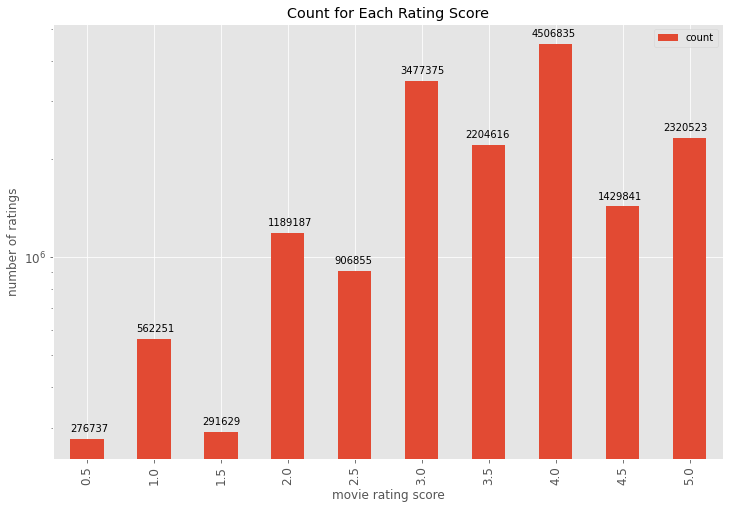

In [78]:
ax = df_ratings_cntRatings[['count']].reset_index().rename(columns={'index': 'rating'}).plot(
    x='rating',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 0.984, p.get_height() * 1.05))

In [79]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print(num_users)
print(num_items)

162541
59047


In [80]:
df_movies_cntMovies = pd.DataFrame(df_merged.groupby('movieId').size(), columns=['count'])
df_movies_cntMovies

,count
movieId,
1,57309
2,24228
3,11804
4,2523
5,11714
...,...
209153,1
209159,1
209163,1


Text(0, 0.5, 'number of ratings (log scale)')

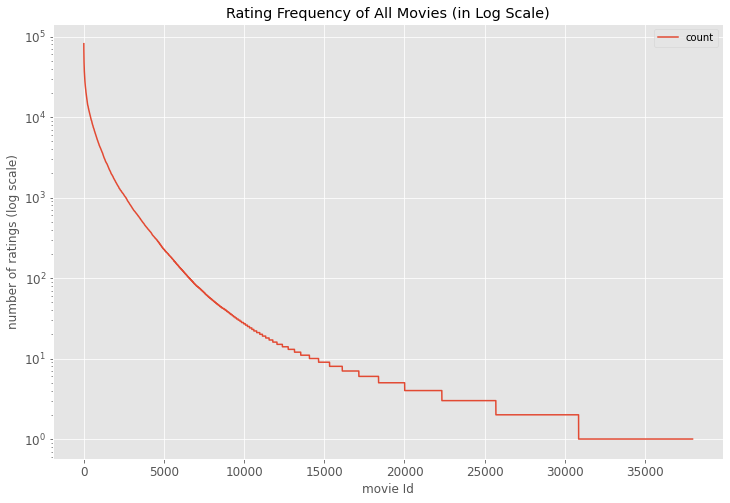

In [81]:
ax = df_movies_cntMovies \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [82]:
df_movies_cntMovies['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    81491.00
0.95     1682.35
0.90      456.90
0.85      158.00
0.80       63.00
0.75       32.00
0.70       18.00
0.65       12.00
Name: count, dtype: float64

In [83]:
popularity_thres = 50
popular_movies = list(set(df_movies_cntMovies.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_merged[df_merged.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_merged.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (17165849, 10)
shape of ratings data after dropping unpopular movies:  (16954138, 10)


In [84]:
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,25
2,116
3,464
4,177
5,72


Text(0, 0.5, 'number of ratings')

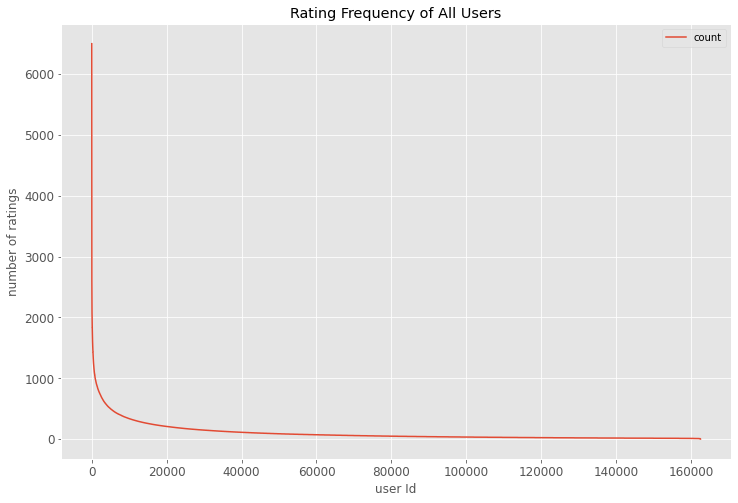

In [85]:
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [86]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    6500.0
0.95     382.0
0.90     243.0
0.85     177.0
0.80     138.0
0.75     111.0
0.70      91.0
0.65      77.0
0.60      66.0
0.55      56.0
Name: count, dtype: float64

In [87]:
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_merged.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (17165849, 10)
shape of ratings data after dropping both unpopular movies and inactive users:  (14752122, 10)


In [88]:
df_ratings_drop_users

,movieId,title,genres,year,titleType,director,writer,userId,rating,timestamp
0,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995,movie,John Lasseter,John Lasseter,2,3.5,1141415820
1,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995,movie,John Lasseter,John Lasseter,3,4.0,1439472215
2,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995,movie,John Lasseter,John Lasseter,4,3.0,1573944252
3,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995,movie,John Lasseter,John Lasseter,5,4.0,858625949
4,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995,movie,John Lasseter,John Lasseter,8,4.0,890492517
...,...,...,...,...,...,...,...,...,...,...
17165526,207830,Terminator: Dark Fate,"[action, sci-fi]",2019,movie,Tim Miller,David S. Goyer,144301,3.5,1572984655
17165527,207830,Terminator: Dark Fate,"[action, sci-fi]",2019,movie,Tim Miller,David S. Goyer,148647,3.0,1572924515
17165528,207830,Terminator: Dark Fate,"[action, sci-fi]",2019,movie,Tim Miller,David S. Goyer,154088,4.0,1573021133
17165529,207830,Terminator: Dark Fate,"[action, sci-fi]",2019,movie,Tim Miller,David S. Goyer,154546,4.0,1572703664


In [ ]:
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [98]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [67]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [68]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = input("Enter your favourite movie:")

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

In [ ]:

# calculates precision for 1:100 dataset with 90 tp and 30 fp
# from sklearn.metrics import precision_score
# define actual
# act_pos = [1 for _ in range(100)]
# act_neg = [0 for _ in range(10000)]
# y_true = act_pos + act_neg
# define predictions
# pred_pos = [0 for _ in range(10)] + [1 for _ in range(90)]
# pred_neg = [1 for _ in range(30)] + [0 for _ in range(9970)]
# y_pred = pred_pos + pred_neg
# calculate prediction
# precision = precision_score(y_true, y_pred, average='binary')
# print('Precision: %.3f' % precision)

# **Genre Based**

In [90]:
#df_movies['genres'] = df_movies['genres'].str.split('|')
df_merged['genres'] = df_merged['genres'].fillna("").astype('str')

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_genre = TfidfVectorizer(analyzer='word', ngram_range=(1,2),min_df=0, stop_words='english')
tfidf_matrix_genre = tf_genre.fit_transform(df_movies['genres'])
tfidf_matrix_genre.shape

(40609, 189)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix_genre,tfidf_matrix_genre)
cosine_sim[:4,:4]

In [9]:
titles = df_merged['title']
indices = pd.Series(df_merged.index, index=df_merged['title'])

def genre_recomm_genre(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    df_movies_indices = [i[0] for i in sim_scores]
    return titles.iloc[df_movies_indices]

In [ ]:
movie = input("Enter you favourite movie: ")
genre_recomm_genre(movie).head(3)

# **Director Based**

In [95]:
df_movies['director'] = df_movies['director'].fillna("").astype('str')

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_dir = TfidfVectorizer(analyzer='word', ngram_range=(1,2),min_df=0, stop_words='english')
tfidf_matrix_dir = tf_dir.fit_transform(df_movies['director'])
tfidf_matrix_dir.shape

(40609, 37667)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix_dir,tfidf_matrix_dir)
cosine_sim[:7,:7]

In [16]:
titles = df_movies['title']
indices = pd.Series(df_movies.index, index=df_movies['title'])

def genre_recomm_dir(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    df_movies_indices = [i[0] for i in sim_scores]
    return titles.iloc[df_movies_indices]

In [27]:
movie = input("Enter you favourite movie: ")
genre_recomm_dir(movie).head(10)

28861         Pro Dia Nascer Feliz
40605           Window of the Soul
20416             O Costa d'África
894                    The Machine
28356                  The Machine
11062                         Rafa
35273                    John From
37073           Um Adeus Português
9793                     Silvestre
12445    Passeio com Johnny Guitar
Name: title, dtype: object